<a href="https://colab.research.google.com/github/Apoorvmittal11/23-CS-072-ML-LAB-EXPERIMENT/blob/main/23-CS-072%20EXPERIMENT7/23_CS_072_Experiment_7(K_Means_Clustering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Experiment-7: Implementing K-Means Clustering from Scratch**

**Objective**

The goal of this assignment is to implement the K-Means clustering algorithm from
scratch using NumPy, apply it to a customer segmentation dataset, and interpret the
clusters formed.

**1. Dataset and Setup**

• Use a customer dataset containing features such as Age, Annual Income (k$), and
Spending Score (1-100).

• Perform basic data exploration and preprocessing:

– Handle missing values if any.

– Normalize or standardize the numerical features (justify your choice).

– Provide relevant summary statistics and visualizations(distribution plots (his-
tograms, scatter matrix) of features.).

In [4]:
import pandas as pd

# Read file as raw text
df_raw = pd.read_csv("/content/Mall_Customers.csv", header=None)

# Split the single column into multiple columns using commas
df = df_raw[0].str.split(",", expand=True)

# Set proper column names from the first row
df.columns = df.iloc[0]
df = df.drop(0).reset_index(drop=True)

# Convert numeric columns to correct data types
numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

print("✅ Fixed Dataset Columns:\n", df.columns.tolist())
print("\nFirst 5 rows:\n", df.head())


✅ Fixed Dataset Columns:
 ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

First 5 rows:
 0 CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0          1    Male   19                  15                      39
1          2    Male   21                  15                      81
2          3  Female   20                  16                       6
3          4  Female   23                  16                      77
4          5  Female   31                  17                      40


Dataset loaded successfully!

Shape of dataset: (200, 5)

Column Names: ['CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']

Data Types:
 0
CustomerID                object
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

First 5 rows:
 0 CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0          1    Male   19                  15                      39
1          2    Male   21                  15                      81
2          3  Female   20                  16                       6
3          4  Female   23                  16                      77
4          5  Female   31                  17                      40

Summary statistics:
 0             Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     1

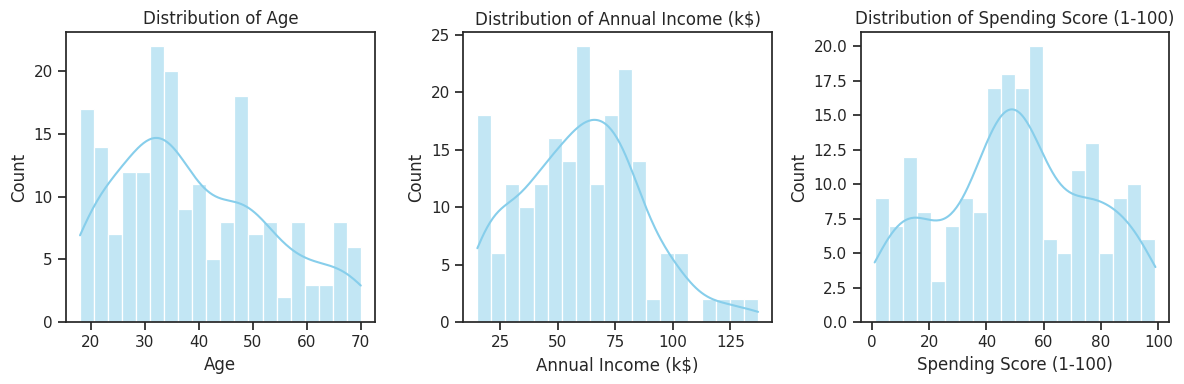

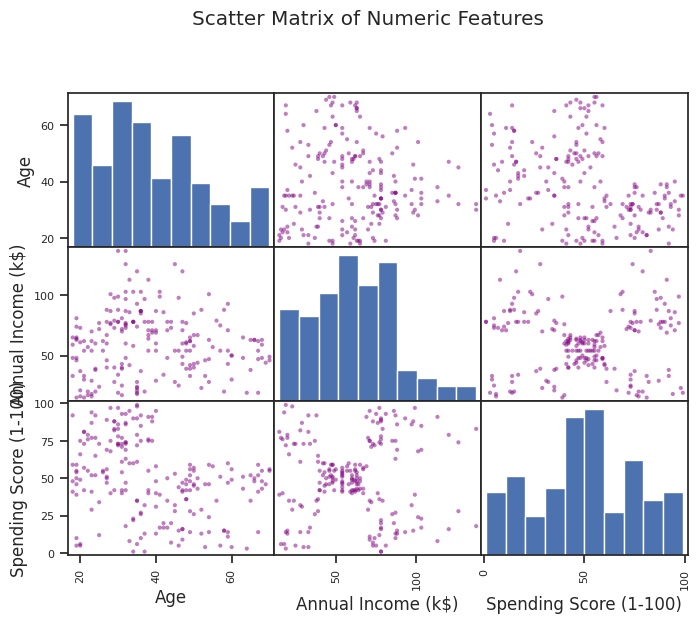

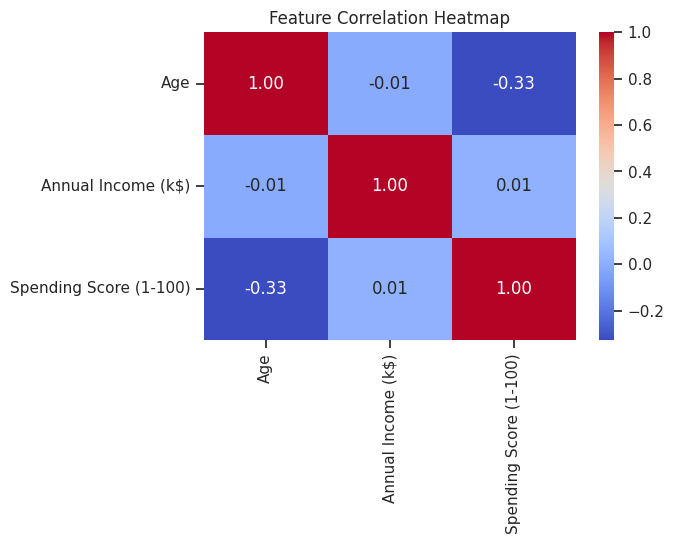

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix

# Load the dataset
df_raw = pd.read_csv("/content/Mall_Customers.csv", header=None)

# Split the single column correctly
df = df_raw[0].str.split(",", expand=True)

# Assign column names and drop the header row from data
df.columns = df.iloc[0]
df = df.drop(0).reset_index(drop=True)

# Convert numeric columns to appropriate types
numeric_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

# Basic info & summary
print("Dataset loaded successfully!\n")
print("Shape of dataset:", df.shape)
print("\nColumn Names:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nFirst 5 rows:\n", df.head())
print("\nSummary statistics:\n", df.describe())

# Handle missing values
print("\nMissing Values per column:\n", df.isnull().sum())

# If any missing values exist, we’ll fill numerical with mean and categorical with mode
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)

# Normalize
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[numeric_cols])
df_scaled = pd.DataFrame(scaled_features, columns=[f"{col}_scaled" for col in numeric_cols])
df = pd.concat([df, df_scaled], axis=1)

print("\n Standardization complete! Mean ≈ 0, Std ≈ 1 for scaled features:\n")
print(df_scaled.describe().round(2))


# Visualizations

# (a) Distribution plots
plt.figure(figsize=(12,4))
for i, col in enumerate(numeric_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# (b) Pairwise scatter matrix
sns.set(style="ticks")
scatter_matrix(df[numeric_cols], figsize=(8,6), diagonal='hist', color='purple')
plt.suptitle("Scatter Matrix of Numeric Features", y=1.02)
plt.show()

# (c) Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()


**2. Tasks**

2.1. Part A: Implementing K-Means from Scratch
Write your own functions for each step of the K-Means algorithm using NumPy only
(no scikit-learn).

**1. Initialization**

• Write a function initialize centroids(X, k, random state=None) that
randomly selects k points as initial centroids.

• Implement the K-Means++ initialization scheme:

1.1. Choose one centroid uniformly at random from the data points.

1.2. For each data point x, compute the squared distance D(x) to the nearest
chosen centroid.

1.3. Choose the next centroid with probability proportional to D(x).

1.4. Repeat until k centroids are chosen.
Compare convergence speed and quality with random initialization.

In [7]:
import numpy as np
#  Initialize Centroids
def initialize_centroids(X, k, random_state=None):
    """
    Randomly selects k points as initial centroids from dataset X.
    """
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[indices]
    return centroids

def kmeans_plus_plus_init(X, k, random_state=None):
    """
    K-Means++ Initialization:
    1. Choose 1st centroid randomly.
    2. Compute distance squared (D(x)) for all points.
    3. Choose next centroid proportional to D(x).
    4. Repeat until k centroids are selected.
    """
    if random_state is not None:
        np.random.seed(random_state)

    n_samples, _ = X.shape
    centroids = []

    # Step 1: Choose first centroid randomly
    first_idx = np.random.randint(n_samples)
    centroids.append(X[first_idx])

    # Step 2–4: Choose the rest
    for _ in range(1, k):
        dist_sq = np.min(np.square(np.linalg.norm(X[:, np.newaxis] - np.array(centroids), axis=2)), axis=1)
        probs = dist_sq / np.sum(dist_sq)
        next_idx = np.random.choice(n_samples, p=probs)
        centroids.append(X[next_idx])

    return np.array(centroids)


**2. Cluster Assignment**

• Implement assign clusters(X, centroids) that assigns each data point to
the nearest centroid (using Euclidean distance).

In [8]:
def assign_clusters(X, centroids):
    """
    Assign each data point to the nearest centroid (Euclidean distance).
    Returns array of cluster labels.
    """
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)
    return labels

**3. Centroid Update**

• Implement update centroids(X, labels, k) that recalculates the centroids
as the mean of all points belonging to each cluster.

In [9]:
def update_centroids(X, labels, k):
    """
    Compute new centroids as mean of all points in each cluster.
    """
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids

**4. Main Algorithm Loop**

• Combine the above steps in a function kmeans(X, k, max iters=100, tol=1e-4,
random state=None).

• The algorithm should stop when:

– The centroid positions change less than tol (tolerance), or

– The maximum number of iterations is reached.

• The function should return:

– Final centroids

– Cluster labels

– Number of iterations

– Inertia (sum of squared distances to centroids)

Random Initialization:
Iterations: 9, Inertia: 168.25

K-Means++ Initialization:
Iterations: 6, Inertia: 168.76



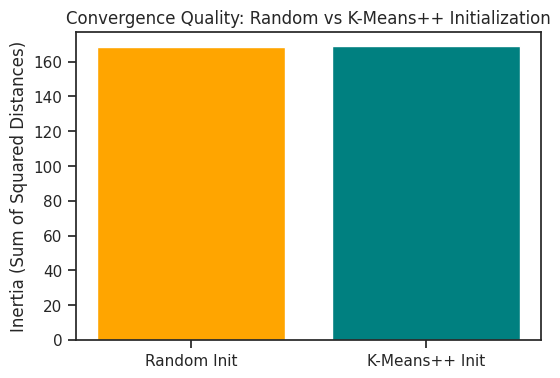

In [11]:
def kmeans(X, k, max_iters=100, tol=1e-4, random_state=None, init_method="random"):
    """
    Runs K-Means clustering from scratch.
    Stops when centroids shift less than tolerance (tol) or max_iters reached.
    Returns:
      - final centroids
      - labels
      - num_iterations
      - inertia (sum of squared distances to nearest centroid)
    """
    # Initialization
    if init_method == "kmeans++":
        centroids = kmeans_plus_plus_init(X, k, random_state)
    else:
        centroids = initialize_centroids(X, k, random_state)

    for iteration in range(max_iters):
        # Step 1: Assign clusters
        labels = assign_clusters(X, centroids)

        # Step 2: Update centroids
        new_centroids = update_centroids(X, labels, k)

        # Step 3: Check for convergence
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tol:
            break
        centroids = new_centroids

    # Compute final inertia (sum of squared distances)
    inertia = np.sum((X - centroids[labels])**2)

    return centroids, labels, iteration + 1, inertia

# Apply to Dataset
# Use the standardized features from Step 1
X = df_scaled.values

# Run both random and kmeans++ initialization
centroids_random, labels_random, iters_random, inertia_random = kmeans(X, k=5, random_state=42, init_method="random")
centroids_pp, labels_pp, iters_pp, inertia_pp = kmeans(X, k=5, random_state=42, init_method="kmeans++")

# Display results
print("Random Initialization:")
print(f"Iterations: {iters_random}, Inertia: {inertia_random:.2f}\n")

print("K-Means++ Initialization:")
print(f"Iterations: {iters_pp}, Inertia: {inertia_pp:.2f}\n")

# Compare convergence visually (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(["Random Init", "K-Means++ Init"], [inertia_random, inertia_pp], color=['orange','teal'])
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Convergence Quality: Random vs K-Means++ Initialization")
plt.show()

**2.2. Part B: Choosing the Number of Clusters**

• Use the Elbow Method and the Silhouette Score to determine an appropriate
k. Compare both

• Plot inertia vs. k and justify your chosen value.

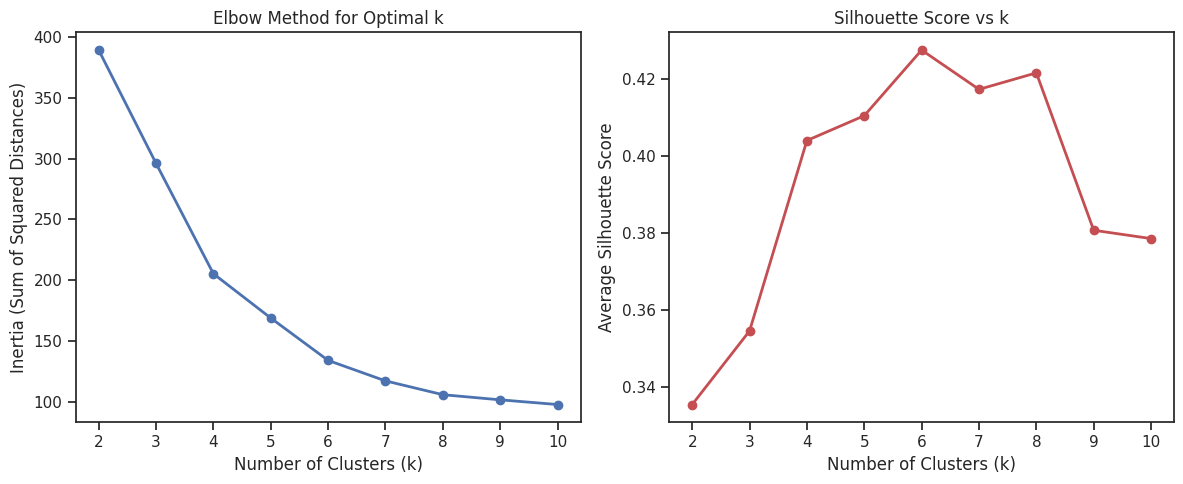

Suggested k (Elbow Method): 10
Suggested k (Silhouette Score): 6


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

X = df_scaled.values

inertias = []
sil_scores = []
K_range = range(2, 11)

for k in K_range:
    centroids, labels, iters, inertia = kmeans(X, k, random_state=42, init_method="kmeans++")
    inertias.append(inertia)

    # Compute silhouette score (only if >1 cluster)
    score = silhouette_score(X, labels)
    sil_scores.append(score)

# Plot Inertia vs K (Elbow Method)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(K_range, inertias, 'bo-', linewidth=2)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")

# Plot Silhouette Score vs K
plt.subplot(1,2,2)
plt.plot(K_range, sil_scores, 'ro-', linewidth=2)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.title("Silhouette Score vs k")

plt.tight_layout()
plt.show()

# Print optimal values
best_k_elbow = np.argmin(np.gradient(np.gradient(inertias))) + 2  # rough elbow detection
best_k_silhouette = K_range[np.argmax(sil_scores)]

print(f"Suggested k (Elbow Method): {best_k_elbow}")
print(f"Suggested k (Silhouette Score): {best_k_silhouette}")


**2.3. Part C: Applying the Algorithm**

• Run your K-Means implementation on the dataset using your chosen k.

• Display:

– Final centroids and cluster sizes.

– 2D and 3D scatter plots of clusters (color by label).

• For each cluster, compute the average of each feature (e.g., Age, Income, Spending

Score). Compare these averages across clusters to identify distinguishing charac-
teristics. Based on these statistics, interpret each cluster in business terms (e.g.,

“Cluster 0: Young, high-income, high-spending customers” or “Cluster 2: Older,
low-income, conservative spenders”).

K-Means completed in 6 iterations
Total Inertia: 168.76

Final Centroids (Standardized Values):


,Age_scaled,Annual Income (k$)_scaled,Spending Score (1-100)_scaled
0,1.198627,-0.460981,-0.327038
1,-0.441917,0.991583,1.239503
2,-0.974396,-1.329545,1.132178
3,0.173295,1.066454,-1.298010
4,-0.781722,-0.403069,-0.215914



 Cluster Sizes:


,count
0,58
1,39
2,22
3,34
4,47


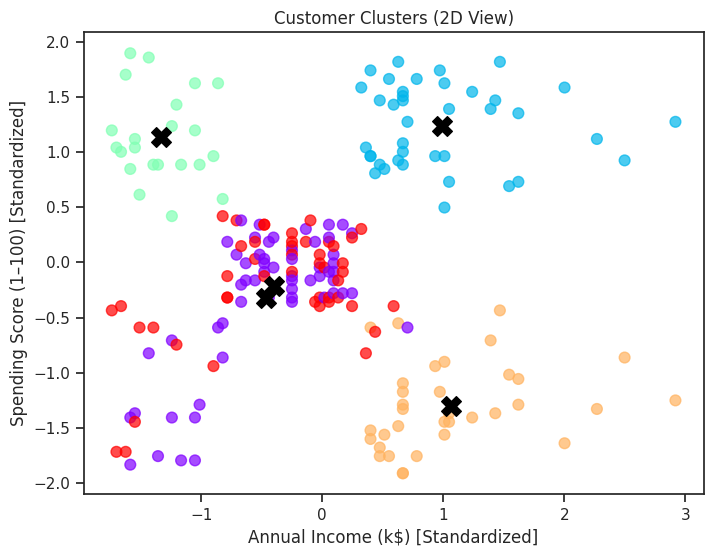

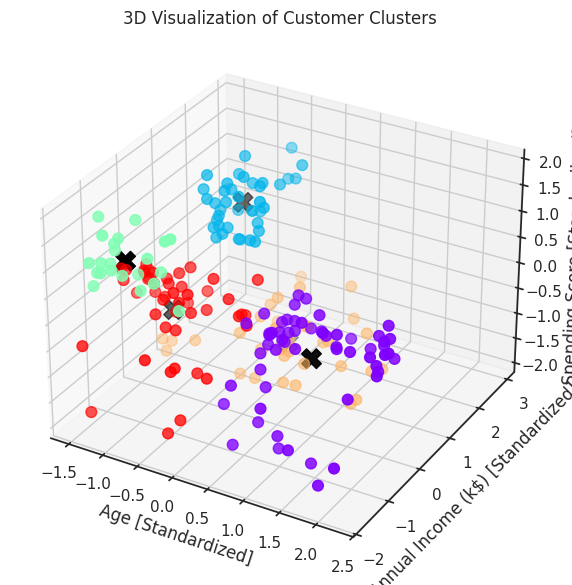

Cluster-wise Average Feature Values (Original Scale):


,Age,Annual Income (k$),Spending Score (1-100)
Cluster,,,
0,55.551724,48.482759,41.775862
1,32.692308,86.538462,82.128205
2,25.272727,25.727273,79.363636
3,41.264706,88.500000,16.764706
4,27.957447,50.000000,44.638298


Cluster 0:
   → Mid-Income/Moderate-Spending Customers 👕 (Average Shoppers)

Cluster 1:
   → Young/High-Income/High-Spending Customers 💸 (Luxury Shoppers)

Cluster 2:
   → Low-Income/High-Spending Customers 🛍️ (Impulsive Buyers)

Cluster 3:
   → High-Income/Low-Spending Customers 💼 (Cautious Spenders)

Cluster 4:
   → Mid-Income/Moderate-Spending Customers 👕 (Average Shoppers)



In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1️⃣ Run K-Means with chosen k
k = 5
X = df_scaled.values

centroids, labels, iters, inertia = kmeans(X, k, random_state=42, init_method="kmeans++")

print(f"K-Means completed in {iters} iterations")
print(f"Total Inertia: {inertia:.2f}\n")

# Final Centroids and Cluster Sizes
centroids_df = pd.DataFrame(centroids, columns=df_scaled.columns)
cluster_sizes = pd.Series(labels).value_counts().sort_index()

print("Final Centroids (Standardized Values):")
display(centroids_df)
print("\n Cluster Sizes:")
display(cluster_sizes)

# 2D and 3D Cluster Visualization
# 2D Plot: Annual Income vs Spending Score
plt.figure(figsize=(8,6))
plt.scatter(X[:,1], X[:,2], c=labels, cmap='rainbow', s=60, alpha=0.7)
plt.scatter(centroids[:,1], centroids[:,2], c='black', s=200, marker='X')
plt.title("Customer Clusters (2D View)")
plt.xlabel("Annual Income (k$) [Standardized]")
plt.ylabel("Spending Score (1–100) [Standardized]")
plt.show()

# 3D Plot: Age, Income, and Spending Score
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=labels, cmap='rainbow', s=60)
ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], c='black', s=200, marker='X')
ax.set_xlabel("Age [Standardized]")
ax.set_ylabel("Annual Income (k$) [Standardized]")
ax.set_zlabel("Spending Score [Standardized]")
ax.set_title("3D Visualization of Customer Clusters")
plt.show()

# Cluster Feature Averages
df_clustered = df.copy()
df_clustered['Cluster'] = labels

cluster_summary = df_clustered.groupby('Cluster')[['Age','Annual Income (k$)','Spending Score (1-100)']].mean()
print("Cluster-wise Average Feature Values (Original Scale):")
display(cluster_summary)

# Interpretation
for i, row in cluster_summary.iterrows():
    print(f"Cluster {i}:")
    age, income, score = row['Age'], row['Annual Income (k$)'], row['Spending Score (1-100)']

    if income > 70 and score > 60:
        print("   → Young/High-Income/High-Spending Customers 💸 (Luxury Shoppers)")
    elif income < 40 and score < 40:
        print("   → Low-Income/Low-Spending Customers 🧺 (Budget-Conscious)")
    elif income >= 60 and score < 40:
        print("   → High-Income/Low-Spending Customers 💼 (Cautious Spenders)")
    elif income < 40 and score > 60:
        print("   → Low-Income/High-Spending Customers 🛍️ (Impulsive Buyers)")
    else:
        print("   → Mid-Income/Moderate-Spending Customers 👕 (Average Shoppers)")
    print()


**2.4. Part D: Comparison with scikit-learn**

• Run sklearn.cluster.KMeans on the same dataset.

• Compare:

– Final centroids and inertia.

– Number of iterations to converge.

– Runtime performance.

In [18]:
import time
from sklearn.cluster import KMeans
X = df_scaled.values
k = 5

# Run your custom K-Means and measure time
start_custom = time.time()
centroids_custom, labels_custom, iters_custom, inertia_custom = kmeans(
    X, k, random_state=42, init_method="kmeans++"
)
end_custom = time.time()
runtime_custom = end_custom - start_custom

# Run sklearn’s KMeans for comparison
start_sklearn = time.time()
kmeans_sklearn = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
kmeans_sklearn.fit(X)
end_sklearn = time.time()
runtime_sklearn = end_sklearn - start_sklearn

# Extract sklearn metrics
centroids_sklearn = kmeans_sklearn.cluster_centers_
labels_sklearn = kmeans_sklearn.labels_
inertia_sklearn = kmeans_sklearn.inertia_
iters_sklearn = kmeans_sklearn.n_iter_

# Compare results
print("COMPARISON: Custom vs Scikit-Learn KMeans")
print("="*60)
print(f"{'Metric':<30}{'Custom Implementation':<20}{'Scikit-Learn':<20}")
print("-"*60)
print(f"{'Final Inertia':<30}{inertia_custom:<20.4f}{inertia_sklearn:<20.4f}")
print(f"{'Iterations to Converge':<30}{iters_custom:<20}{iters_sklearn:<20}")
print(f"{'Runtime (seconds)':<30}{runtime_custom:<20.6f}{runtime_sklearn:<20.6f}")
print("="*60)


# Compare centroids visually
centroid_diff = np.linalg.norm(centroids_custom - centroids_sklearn, axis=1)
print("\n Average centroid difference per cluster (Euclidean distance):")
print(np.round(centroid_diff, 6))


COMPARISON: Custom vs Scikit-Learn KMeans
Metric                        Custom ImplementationScikit-Learn        
------------------------------------------------------------
Final Inertia                 168.7618            168.2476            
Iterations to Converge        6                   9                   
Runtime (seconds)             0.003812            0.030206            

 Average centroid difference per cluster (Euclidean distance):
[1.400287 1.973659 2.369585 0.168849 2.000292]
